In [1]:
%pip install kapre==0.1.7 --quiet
%pip install soundfile --quiet

CONNECTING G- DRIVE

IMPORT LIBS

In [3]:
import os
import numpy as np
import kapre
import librosa
import random
import tensorflow as tf
import soundfile as sf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential,Model
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [7]:
data_dir = '/content/drive/MyDrive/ai and ml/'
os.chdir(data_dir)

data_x = []
data_y = []
for a,i in enumerate(['back','left','frwrd','right','stop']):
    lis = os.listdir(data_dir+i)
    for j in lis:
        l,sr = sf.read(data_dir+i+'/'+j)
        data_x.append(l[0:16000])
        data_y.append(a)


data_x = np.array(data_x)
data_y = np.array(data_y)


np.save('x.npy',data_x)
np.save('y.npy',data_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  



Splitting data into Train and Test

In [8]:

np_load_old = np.load

np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

data_x = np.load('x.npy')
data_y = np.load('y.npy')
tr_x,te_x, tr_y,te_y = train_test_split(data_x,data_y,stratify=data_y,random_state=42,test_size=0.25)
np.load = np_load_old

In [9]:
x_train = []
y_train = []
for i,j in enumerate(tr_x):
    x= len(j)
    p = 25000-x
    for y in range(1 ,p, 500):
        nx = np.zeros(25000)
        nx[y:y+x] =j
        x_train.append(nx)
        y_train.append(tr_y[i])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i,j in enumerate(te_x):
    x= len(j)
    p = 25000-x
    for y in range(1 ,p, 500):
        nx = np.zeros(25000)
        nx[y:y+x] =j
        x_test.append(nx)
        y_test.append(te_y[i])
x_test = np.array(x_test)
y_test = np.array(y_test)

np.save('x_train.npy',x_train)
np.save('y_train.npy',y_train)
np.save('x_test.npy',x_test)
np.save('y_test.npy',y_test)

In [10]:
mfcc = Sequential()
mfcc.add(L.Reshape((1, -1)))
mfcc.add(Melspectrogram(padding='same', sr=16000, n_mels=39, n_dft = 1024,
                        power_melgram=2.0, return_decibel_melgram=True,
                        trainable_fb=False, trainable_kernel=False,
                        name='mel_stft'))
mfcc.add(Normalization2D(str_axis='freq'))
mfcc.add(L.Permute((2, 1, 3)))

x_train = mfcc.predict(x_train)
x_train.shape

x_test = mfcc.predict(x_test)
x_test.shape

np.save('mfcc_train.npy',x_train)
np.save('mfcc_test.npy',x_test)

In [12]:
# Change the directory 
data_dir = '/content/drive/MyDrive/ai and ml/'
os.chdir(data_dir)
x_train = np.load('mfcc_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('mfcc_test.npy')
y_test = np.load('y_test.npy')

In [13]:

# https://github.com/douglas125/SpeechCmdRecognition/blob/master/SpeechModels.py

os.environ['PYTHONHASHSEED']='123'
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)

def AttentionModel(sr=16000, iLen=25000):
    inputs = L.Input(x_train.shape[1:], name='Input')
    x = L.Conv2D(10, (5, 1), activation='relu', padding='same', name='Conv1')(inputs)
    x = L.BatchNormalization(name='BN1')(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same', name='Conv2')(x)
    x = L.BatchNormalization(name='BN2')(x)
    
    x = L.Reshape(x.shape[1:-1],name='Squeeze')(x)

    n_units = 64
    x = L.LSTM(n_units, return_sequences=True, name='LSTM_Sequences')(x)  

    # Calculate Unit Importance
    xLast = L.Lambda(lambda q: q[:, -1], name='FinalSequence')(x)  # [b_s, vec_dim]
    xLast = L.Dense(xLast.shape[-1], name='UnitImportance')(xLast)

    # Calculate attention
    attScores = L.Dot(axes=[1, 2],name='AttentionScores')([xLast, x])
    attScores = L.Softmax(name='AttentionSoftmax')(attScores)  

    x = L.Dot(axes=[1, 1], name='AttentionVector')([attScores, x])  
    x = L.Dense(32, activation='relu', name='FC')(x)
    outputs = L.Dense(5, activation='softmax', name='Output')(x)
    model = Model(inputs=[inputs], outputs=[outputs], name='Attention')

    return model

model = AttentionModel()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])


Model Summary

In [14]:
model.summary()

Model: "Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 49, 39, 1)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 49, 39, 10)   60          Input[0][0]                      
__________________________________________________________________________________________________
BN1 (BatchNormalization)        (None, 49, 39, 10)   40          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 49, 39, 1)    51          BN1[0][0]                        
__________________________________________________________________________________________

In [15]:
my_model = model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=10,shuffle=True,batch_size= 15)

Epoch 1/10
430/430 [==============================] - 30s 64ms/step - loss: 0.5266 - sparse_categorical_accuracy: 0.7758 - val_loss: 0.0324 - val_sparse_categorical_accuracy: 0.9889
Epoch 2/10
430/430 [==============================] - 27s 63ms/step - loss: 0.0026 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0030 - val_sparse_categorical_accuracy: 0.9991
Epoch 3/10
430/430 [==============================] - 27s 63ms/step - loss: 5.7471e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0018 - val_sparse_categorical_accuracy: 0.9991
Epoch 4/10
430/430 [==============================] - 27s 63ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9943 - val_loss: 7.2435e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/10
430/430 [==============================] - 27s 62ms/step - loss: 4.2150e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.8417e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/10
430/430 [==============================] - 27s 63ms/step - loss

Acccuracy of the model

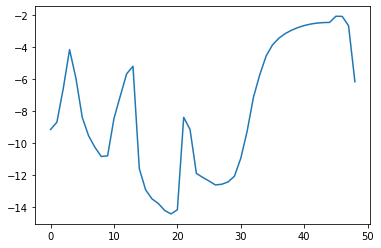

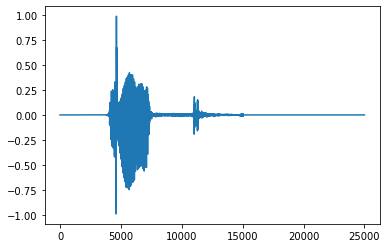

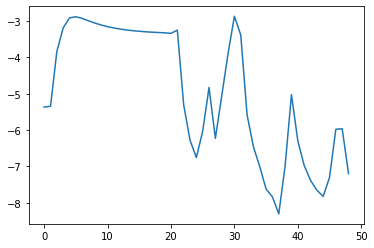

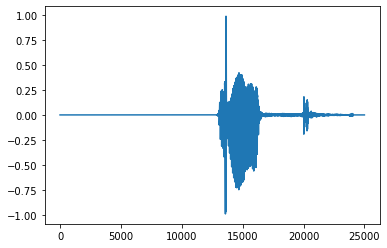

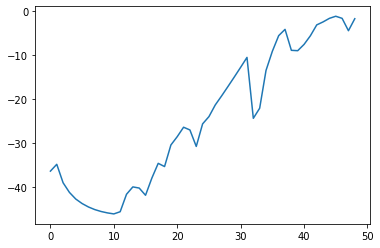

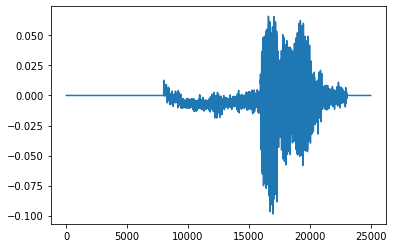

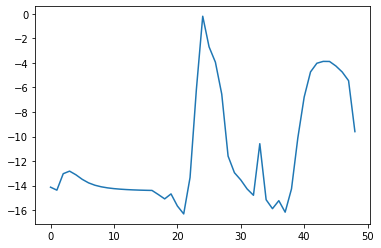

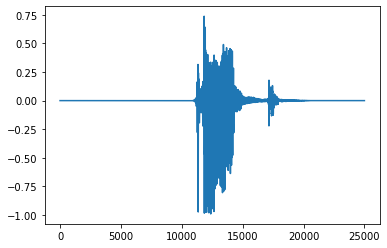

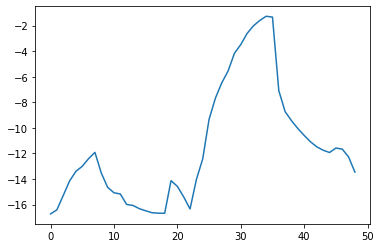

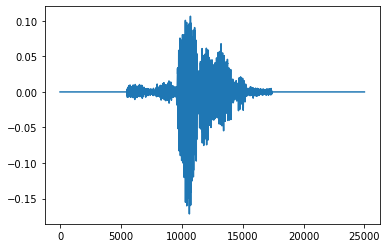

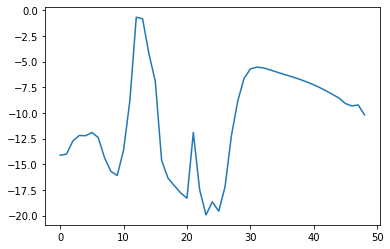

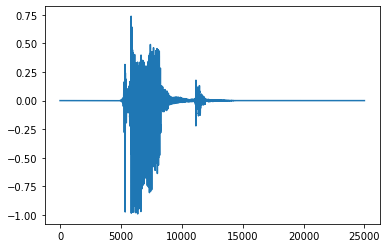

In [19]:

from matplotlib import pyplot as plt
model2 = Model(inputs=model.input, outputs=[model.get_layer('Output').output, 
                                            model.get_layer('AttentionSoftmax').output])
data_dir = '/content/drive/MyDrive/ai and ml/'
os.chdir(data_dir)
a,b = model2.predict(x_test)
xx_test = np.load('x_test.npy')
for aid in range(0,100,18):
    plt.plot(range(len(b[aid])), np.log(b[aid]))
    plt.show()
    plt.plot(range(len(xx_test[aid])),xx_test[aid])
    plt.show()